### Transfer Learning using InceptionV3

In [1]:
#######################################################################################
# 1.0 Call libraries
import cv2     # Image manipulation module
               #  of OpenCV library

# 1.2
import numpy as np
import pandas as pd

# 1.3
from keras.models import  Sequential
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Dropout, GlobalAveragePooling2D

# 1.4 We will use these callbacks()
# 1.4.1 For storing model with minimum loss after every epoch
from keras.callbacks import ModelCheckpoint
# 1.4.2 Stop training when val_loss does not decrease enough
from keras.callbacks import EarlyStopping
# 1.4.3 Reduce learning rate when val_loss stops improving
from keras.callbacks import ReduceLROnPlateau

# 1.5
import matplotlib.pyplot as plt
import os, time


Using TensorFlow backend.


In [2]:
# 2.0 Define constants
img_height = 150
img_width = 150
img_channels = 3
img_dim = (img_height, img_width, img_channels)
img_size = (img_height, img_width)
batch_size = 5
epochs = 5

In [3]:
path = "D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/"

In [4]:
# 3.1 Read filenames vs target-values
train_set = pd.read_csv('D:/ShreeTechnical/MLDL/Classes/EX/ex12/train_labels.csv')
train_set.head()     # Ist coluumn is 'name' ie filename,
                     # IInd column is 'invasive'
train_set.shape      # (2295, 2)

(2295, 2)

In [5]:
# 3.2 Define a function that returns
#     i) A list of files with full-path
#    ii) A data frame, with filenames (with full path) & target-values
#   iii) A 1D array of labels--invasive or non-invasive
def load_train(path):
    # 3.2.1 An empty list to store full filenames
    train_files = []
    # 3.2.2 Get an array of image labels
    train_label = np.array(train_set['invasive'])
    # 3.2.3. We need not peep into folder
    #        Our filenames are 1.jpg, 2.jpg etc
    #
    for i in range(train_set.shape[0]):
        # 3.2.4 Create a filename with path
        filename=str(int(train_set.iloc[i,0])) +'.jpg'
        # 3.2.5 Append it to filename list
        train_files.append(path + filename)

    # 3.2.6 Finally replace existing values in 'name' column
    #       with filepaths
    train_set['name'] = train_files
    # 3.2.7 Return the three objects
    return train_files, train_set, train_label

In [6]:
# 3.3 Now use load_train() to get desired output
train_files, train_set, train_label = load_train(path)

In [7]:
# 3.4 Check all three output
train_label[:5]

array([0, 0, 1, 0, 1], dtype=int64)

In [8]:
train_set.head(5)

,name,invasive
0,D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/1...,0
1,D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/2...,0
2,D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/3...,1
3,D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/4...,0
4,D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/5...,1


In [9]:
train_files[:5]

['D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/1.jpg',
 'D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/2.jpg',
 'D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/3.jpg',
 'D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/4.jpg',
 'D:/ShreeTechnical/MLDL/Classes/EX/ex12/train/5.jpg']

In [10]:
# 3.5 We assume our data is shuffled enough
# 3.5.1 Here is our train data
x_train = train_set.iloc[:2000,:]     # x_train is pandas dataframe
y_train =train_label[:2000]           # Numpy array

In [11]:
# 3.5.2 And our validation data
x_valid = train_set.iloc[2000:,:]     # 295 images
y_valid =train_label[2000:]

In [12]:
# 4.0 Quickly construct a simple Sequential model

# 4.1 Download inception weights and create its model
#     File size is 88MB. Download is one time to folders
#     /home/ashok/.keras/models

base_model = InceptionV3(include_top=False,
                         weights='imagenet',
                         input_shape=img_dim
                         )

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# 4.2 Look at the model
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [14]:
# 4.3 Total number of layers are:
len(base_model.layers)      # 311

311

In [15]:
# 4.4 Look at layer names again
for i,layer in enumerate(base_model.layers):
    print((i,layer.name))

(0, 'input_1')
(1, 'conv2d_1')
(2, 'batch_normalization_1')
(3, 'activation_1')
(4, 'conv2d_2')
(5, 'batch_normalization_2')
(6, 'activation_2')
(7, 'conv2d_3')
(8, 'batch_normalization_3')
(9, 'activation_3')
(10, 'max_pooling2d_1')
(11, 'conv2d_4')
(12, 'batch_normalization_4')
(13, 'activation_4')
(14, 'conv2d_5')
(15, 'batch_normalization_5')
(16, 'activation_5')
(17, 'max_pooling2d_2')
(18, 'conv2d_9')
(19, 'batch_normalization_9')
(20, 'activation_9')
(21, 'conv2d_7')
(22, 'conv2d_10')
(23, 'batch_normalization_7')
(24, 'batch_normalization_10')
(25, 'activation_7')
(26, 'activation_10')
(27, 'average_pooling2d_1')
(28, 'conv2d_6')
(29, 'conv2d_8')
(30, 'conv2d_11')
(31, 'conv2d_12')
(32, 'batch_normalization_6')
(33, 'batch_normalization_8')
(34, 'batch_normalization_11')
(35, 'batch_normalization_12')
(36, 'activation_6')
(37, 'activation_8')
(38, 'activation_11')
(39, 'activation_12')
(40, 'mixed0')
(41, 'conv2d_16')
(42, 'batch_normalization_16')
(43, 'activation_16')
(44, 'c

In [16]:
# 4.5 Initialise: Freeze all layers from training
for layer in base_model.layers:
    layer.trainable = False

In [17]:
# 4.6 Make layers 300 onwards available for training
#     Increasing training layers may reduce speed
#     as also accuracy

for layer in base_model.layers[300:]:
    layer.trainable = True

In [18]:
# 4.7 Quick Check
for layer in base_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [19]:
# 4.8 Continue to build model
my_new_model = Sequential()
my_new_model.add(base_model)    # Nested model
my_new_model.add(GlobalAveragePooling2D())
my_new_model.add(Dropout(0.2))
my_new_model.add(Dense(1, activation='sigmoid'))
my_new_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,561
Non-trainable params: 21,802,272
_________________________________________________________________


In [20]:
## Image augmentation and Data generator
# 5.0 We will augment/modify every image as here;
#     src:   image array (one image)
#     choice: A random number between 0 to 5
#     So carry an action on image, depending upon value
#     of 'choice'
def augment(src, choice):
    if choice == 0:
        # Rotate 90
        src = np.rot90(src, 1)
    if choice == 1:
        # flip vertically
        src = np.flipud(src)
    if choice == 2:
        # Rotate 180
        src = np.rot90(src, 2)
    if choice == 3:
        # flip horizontally
        src = np.fliplr(src)
    if choice == 4:
        # Rotate 90 counter-clockwise
        src = np.rot90(src, 3)
    if choice == 5:
        # Rotate 180 and flip horizontally
        src = np.rot90(src, 2)
        src = np.fliplr(src)
    return src

In [21]:
# 6.0 train data generator
def train_generator():
    while True:
        # 6.1 'start' is incremented in steps of batch_size
        for start in range(0, len(x_train), batch_size):
            x_batch = []     # A list of images. Size = batch_size
            y_batch = []
            # 6.2 Calculate what will be our end-point
            end = min(start + batch_size, len(x_train))
            # 6.3 Read rows of data set x_train in batches
            train_batch = x_train[start:end]
            # 6.4 For every filepath and target label in every row,
            for filepath, label in train_batch.values:
                # 6.5 Read image of that file
                img = cv2.imread(filepath)
                # 6.6 Resize image
                img = cv2.resize(img, img_size)
                # 6.7 Send the image to augment() along with a
                #     random number
                img = augment(img, np.random.randint(6))
                # 6.8 Append our image to the list
                x_batch.append(img)
                y_batch.append(label)
            # 6.9 Normalize images
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.uint8)
            # 6.10 x_batch is a list of batch images
            #      And each image is of dim (img_width,img_height,3)
            #      y_batch is a 1D array
            yield x_batch, y_batch

In [22]:
# 7.0 Just check by using generator
a = train_generator()
x,y = next(a)
x.shape     # (5, 75, 75, 3)
y.shape     # (5,)
x[0,...]    # Ist image, 3 channels
x[0,...].shape   # (75, 75, 3)
len(x)      # 5
y

array([0, 0, 1, 0, 1], dtype=uint8)

In [23]:
# 7.1 SImilarly design validation data generator
def valid_generator():
    while True:
        for start in range(0, len(x_valid), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(x_valid))
            valid_batch = x_valid[start:end]
            for filepath, label in valid_batch.values:
                img = cv2.imread(filepath)
                img = cv2.resize(img, img_size)
                img = augment(img, np.random.randint(6))
                x_batch.append(img)
                y_batch.append(label)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

In [24]:
# 8. Define Callback list
callbacks = [
             # 8.1 Stop training when a monitored quantity has stopped improving.
             EarlyStopping(monitor='val_loss',
                           patience=3,  # number of epochs with no
                                        #  improvement after which
                                        #   training will be stopped.
                           verbose=1,
                           min_delta=1e-4 # an absolute change of less
                                          #  than min_delta, will count
                                          #    as no improvement.
                           ),
            # 8.2 Models often benefit from reducing
            #     learning rate by a factor of 2-10
            #     once learning stagnates.
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=1, # Reduce lr, if no imporvement by 'patience'
                                           # no of epochs
                               cooldown=1, # number of epochs to wait before resuming
                                           # normal operation after lr has been reduced.
                               verbose=1,
                               min_lr=1e-7  # lower bound on the learning rate
                               ),
             # 8.3  Save the model after every epoch if val_loss reduces
             ModelCheckpoint(filepath='inception.fold' +  '.hdf5',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True
                             )
            ]

In [25]:
# 9. Compile model
my_new_model.compile(
                     optimizer=Adam(lr=1e-4),
                     loss='binary_crossentropy',
                     metrics = ['accuracy']
                     )

In [26]:
# 10. Decide number of times to call each generator per epoch:

train_steps = len(x_train) / batch_size
valid_steps = len(x_valid) / batch_size


In [27]:
# 10.1 And start training
start = time.time()
history = my_new_model.fit_generator(
                                     train_generator(),
                                     train_steps,
                                     epochs=epochs,
                                     verbose=1,
                                     callbacks=callbacks,
                                     validation_data=valid_generator(),
                                     validation_steps=valid_steps
                                     )

end = time.time()
(end-start)/60

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
400/400 [==============================] - 370s 924ms/step - loss: 0.6859 - acc: 0.5920 - val_loss: 0.6305 - val_acc: 0.6508

Epoch 00001: val_loss improved from inf to 0.63052, saving model to inception.fold.hdf5
Epoch 2/5
400/400 [==============================] - 176s 439ms/step - loss: 0.6209 - acc: 0.6735 - val_loss: 0.6016 - val_acc: 0.6847

Epoch 00002: val_loss improved from 0.63052 to 0.60155, saving model to inception.fold.hdf5
Epoch 3/5
400/400 [==============================] - 139s 348ms/step - loss: 0.5918 - acc: 0.6860 - val_loss: 0.5706 - val_acc: 0.6644

Epoch 00003: val_loss improved from 0.60155 to 0.57058, saving model to inception.fold.hdf5
Epoch 4/5
400/400 [==============================] - 139s 347ms/step - loss: 0.5599 - acc: 0.7175 - val_loss: 0.5572 - val_acc: 0.6915

Epoch 00004: val_loss improved from 0.57058 to 0.55715, saving model to inception.fold.hdf5
Epoch 5/5
400/400 [=========================

16.32628577152888

In [28]:
# 10.3
#     How accuracy changes as epochs increase
def plot_learning_curve():
    val_acc = history.history['val_acc']
    tr_acc=history.history['acc']
    epochs = range(1, len(val_acc) +1)
    plt.plot(epochs,val_acc, 'b', label = "Validation accu")
    plt.plot(epochs, tr_acc, 'r', label = "Training accu")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

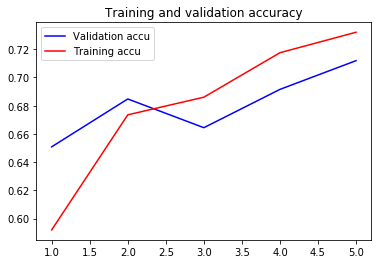

In [29]:
# 10.2 Plot training accuracy and validation accuracy
plot_learning_curve()